# SVM with Interactive User Inputs


## Dependencies

This script was executed using the following version of Python:
* **Python 3.6.2 :: Anaconda, Inc.**

Use this link to install Python on your machine:
* https://www.anaconda.com/distribution/#download-section

**About Python Versions:**
If you are running a higher-version of Python and this notebook fails to execute properly, you can downgrade your version in the terminal by running the following commands:
* conda search python [to see which versions are available on your machine]
* conda install python=3.6.2 [which will switch the active version to 3.6.2; if available in the list above]

**About Python Packages:**
All packages used in this notebook can be installed on your machine using the "pip install [package_name]" command on your terminal.  Be sure you've installed each of the packages below before attempting to execute the notebook.

Current package requirements include:
* os - https://docs.python.org/3/library/os.html
* Pandas - https://pandas.pydata.org/
* Datetime - https://docs.python.org/3/library/datetime.html
* re - https://docs.python.org/3/library/re.html
* Numpy - http://www.numpy.org/
* ipywidgets - https://ipywidgets.readthedocs.io/en/stable/user_install.html
* ipython - https://ipython.org/ipython-doc/rel-0.10.2/html/interactive/extension_api.html
* h2o - http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html#install-in-python
* scikit-learn - https://scikit-learn.org/stable/install.html
* requests - https://2.python-requests.org/en/master/user/install/
* io - https://docs.python.org/3/library/io.html
* warnings - https://docs.python.org/3/library/warnings.html

The current template uses the following versions:
* os== module 'os' from '/anaconda3/lib/python3.6/os.py'
* pandas==0.24.1
* datetime== module 'datetime' from '/anaconda3/lib/python3.6/datetime.py'
* re== module 're' from '/anaconda3/lib/python3.6/re.py'
* numpy==1.16.1
* ipywidgets==7.4.2
* ipython==6.2.1
* h2o==3.24.0.4
* scikit-learn==0.19.1
* requests==2.18.4
* io== module 'io' from '/anaconda3/lib/python3.6/io.py'
* warnings== module 'warnings' from '/anaconda3/lib/python3.6/warnings.py'

## Before you begin, ensure you've installed the required Python packages

* See the list above and make note of the specific versions that were used in this notebook

In [1]:
############################################
###### Import required Python packages #####
############################################

import os
import pandas as pd
import re
import datetime as dt
import numpy as np
from ipywidgets import interact, interactive, IntSlider, Layout
import ipywidgets as widgets
from IPython.display import display
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import io
import requests
import warnings
warnings.filterwarnings('ignore')

## Note: Code Cells are Hidden by Default for Ease-of-Use

This notebook incorporates interactive "widgets" which will result in large blocks of cells being utilized to enable specific user-interactions.  Executing this cell will hide all "Code" cells while making all outputs visible to the user.  Refer to the link below for the source or simply "run" the block below to see the impact on the rest of the notebook.

* https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

#### Disclaimer:
* As the "output text" notes, simply click the "here" hyperlink in the text to toggle on/off this feature

In [54]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 1.0 - Data Ingestion

The series of code blocks below will walk you through the process of mapping to your working directory and uploading your dataset.

## 1.1 - Set Your Working Directory

Your "working directory" is a folder location on your computer that will store files either read-in or written-out by this script.  This code by default will return your current, active directory.  You can change this directory by typing in a specific path into the text box provided.

## AN IMPORTANT NOTE ABOUT INTERACTIVE WIDGETS

This notebook uses interactive widgets to help you make selections and inputs more conveniently.  As you work through this notebook, be sure to follow the steps below to ensure your selections are incorporated in the cells that follow:

#### 1. Run the cell containing the interactive widget(s) to bring them into view
#### 2. Apply your selections and/or inputs to the widgets that appear
#### 3. DO NOT rerun the cell as it will erase your selections and inputs
#### 4. To proceed, simply click on the next cell in the notebook, and Run it

<br/>

In [2]:
set_working_directory = widgets.Text(
    value=os.getcwd(),
    placeholder='/Users/bblanchard006/Desktop/SMU/QTW/Week 9/Summer 2021',
    description='Directory:',
    disabled=False,
    layout=Layout(width='50%')
)

display(set_working_directory)

Text(value='/Users/bblanchard006/Desktop/SMU/QTW/Week 9/Summer 2021', description='Directory:', layout=Layout(…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

After executing the cell above, you can leave the default directory or overwrite the text string that appears with your desired folder directory. **DO NOT execute the cell again after making your update.** The input above will be fed into the following code cell, where it will either successfully map to the new directory or notify you of an error.

In [3]:
try:
    os.chdir(set_working_directory.value)
    print('Changed directory to {}'.format(set_working_directory.value))
except Exception as e:
    print('Failed to change directory')
    print(e)

Changed directory to /Users/bblanchard006/Desktop/SMU/QTW/Week 9/Summer 2021


## 1.2 - Upload Your Data (Excel and CSV files)

The function in the code cell below will find, ingest, and format both xlsx and csv files.  This is the dataset with "known" values which will be used to train your models.

In [4]:
########################################
##### Data Ingestion Functions
########################################

def compile_raw_data(filename, tab_names, subfolder, delimiter_char = ',', skip_rows = 0, file_ext = 'xlsx'):
    
    # Inputs: 
    ## filename = 'sample.csv' | 'sample.xlsx' - the filename in the directory (including the extension) 
    ## tab_names = None | ['Sheet1,'Sheet2'] - None for csv; [comma separated list of tab names] for xlsx
    ## subfolder = 'source_data' - string containing the name of a folder in the working directory
    ## delimiter_char = ',' | ';' - None for xlsx
    ## rows to skip = default 0 - Not used for csv; trims the user-defined number of rows from an xlsx
    ## file extension = csv | xlsx
    
    # Description: reads in the workbook; standardizes header names; 
    # Outputs: returns a dictionary of dataframes

    master_data = {}
    if subfolder:
        file_path = subfolder+'/{}'.format(filename)
    else:
        file_path = filename

    if file_ext == 'csv':
        tab_names = [re.sub('.csv','', filename)]

    for tab in tab_names:
        try:
            if file_ext == 'xlsx':
                dframe = pd.read_excel(file_path, tab, skip_rows)
            elif file_ext == 'csv' and delimiter_char == ',':
                dframe = pd.read_csv(file_path, header=0, delimiter=',')
            else:
                dframe = pd.read_csv(file_path, header=0, delimiter=';')
                
            sanitizer = {
                        '$':'USD',
                        '(':' ',
                        ')':' ',
                        '/':' ',
                        '-':' ',
                        ',':' ',
                        '.':' '
            }
                        
            for key, value in sanitizer.items():
                dframe.rename(columns=lambda x: x.replace(key, value), inplace=True)
                
            dframe.rename(columns=lambda x: x.strip(), inplace=True)
            dframe.rename(columns=lambda x: re.sub(' +','_', x), inplace=True)
            
            dframe.columns = map(str.lower, dframe.columns)
            
            master_data.update({tab:dframe})
        except Exception as e:
            master_data.update({tab:'Failed'})
    
    return master_data

The code blocks below enable conditional filtering to support multiple file types. Further instructions are provided below:

**Uploading csv files**

To upload a csv file, complete these steps:
1. Type in your filename along with the extension (ex. sample.csv)
2. Check the 'csv' radio-button
3. Is your file in the main directory or a sub-folder in the directory:
    * Select the "no" radio-button if your file is in your main directory
    * Select the "yes" radio-button to expose a text-box where you can type-in the name of your sub-folder
    
**Uploading xlsx files**

To upload an xlsx file, complete these steps:
1. Type in your filename along with the extension (ex. sample.xlsx)
2. Check the 'xlsx' radio-button
3. Type in the tab-names you'd like to ingest (comma-separated; Sheet1,Sheet2,Sheet3)
4. If the data in your file has leading rows, select how many rows to skip before ingesting the data (ex. if your data starts on Row 2 in the Excel-file, set the Skip Rows value to 1)
5. Is your file in the main directory or a sub-folder in the directory:
    * Select the "no" radio-button if your file is in your main directory
    * Select the "yes" radio-button to expose a text-box where you can type-in the name of your sub-folder

In [5]:
upload_type = widgets.RadioButtons(
    options=['local', 'url'],
    description='File Location:',
    disabled=False
)

upload_url = widgets.Text(
#    value='https://gist.githubusercontent.com/bradblanch/53857ddb24ad83287b900aa8968ff416/raw/790b0a27392f69a5efcf2c1ac7d0bdad5e38428e/artificial_attrition_data.csv',
    value='https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv',
    placeholder='http://',
    description='URL:',
    disabled=False,
    layout=Layout(width='80%')
)
upload_filename = widgets.Text(
    value='log2.csv',
#     value='Artificial Employment Data.xlsx'
    placeholder='Sample File.csv',
    description='File Name:',
    disabled=False,
    layout=Layout(width='50%')
)

file_type = widgets.RadioButtons(
    options=['csv', 'xlsx'],
    description='File Type:',
    disabled=False
)

tab_names = widgets.Text(
    value='Sheet1, Sheet2, Sheet3, etc',
    placeholder='ALL EMPLOYEES, PAST EMPLOYEES',
    description='Tab(s):',
    disabled=False,
    layout=Layout(width='50%')
)

subfolder_name = widgets.Text(
    value='source_data',
    placeholder='Subfolder name',
    description='Subfolder:',
    disabled=False,
    layout=Layout(width='50%')
)

subfolder = widgets.RadioButtons(
    options=['no','yes'],
    value='no',
    description='Subfolder:',
    disabled=False
)

skip_rows = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Skip Rows:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

delimiter = widgets.RadioButtons(
    options=[',',';'],
    value=',',
    description='Delimiter:',
    disabled=False
)

def text_field(x):
    if(x=='xlsx'):
        display(tab_names)
        tab_names.on_submit(tab_names)
        display(skip_rows)
    else:
        display(delimiter)
        print('Tab Names: Not needed for csv files')

def sub_folder(y):
    if(y=='yes'):
        display(subfolder_name)
        subfolder_name.on_submit(subfolder_name)
    else:
        print('Using {} folder'.format(os.getcwd()))

def file_location(z):
    if(z=='local'):
        display(upload_filename)
        i = widgets.interactive(text_field, x=file_type)
        display(i)
        p = widgets.interactive(sub_folder, y=subfolder)
        display(p)
    else:
        display(upload_url)
    
q = widgets.interactive(file_location, z=upload_type)

display(q)

interactive(children=(RadioButtons(description='File Location:', options=('local', 'url'), value='local'), Out…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

The following code cell will attempt to ingest the data you've selected in the widgets above:

**Note About xlsx Files** - Depending on the number of tabs and the size of the data on each tab, ingesting an xlsx file can take several minutes to execute.  If possible, it may be more efficient to break your Excel file into separate csv files which take only a fraction of a second to ingest.

In [6]:
master_data = {}

if upload_type.value == 'url':
    url_response = requests.request("GET", upload_url.value)
    master_data['url_data'] = pd.read_csv(io.BytesIO(url_response.content))
else:
    if file_type.value == 'csv':
        tabs = None
        skiprows = 0
    else:
        tabs = [x.strip() for x in tab_names.value.split(',')]
        skiprows = skip_rows.value

    if subfolder.value == 'yes':
        subfolder = subfolder_name.value
    else:
        subfolder = None
    master_data = compile_raw_data(upload_filename.value, tabs, subfolder, delimiter_char = delimiter.value, skip_rows = skiprows, file_ext = file_type.value)


**Note:** If you see an AttributeError: 'NoneType' object has no attribute 'value' message above, simply rerun the last two code cells to reset the input parameters.

The following code cell will print out the attributes associated with the files you've uploaded and alert you of any errors:

In [7]:
for key, value in master_data.items():
    try:
        print('{} table was ingested with {} rows and {} columns'.format(key,value.shape[0],value.shape[1]))
    except:
        print('{} table failed to load'.format(key))

log2 table was ingested with 65532 rows and 12 columns


## 1.3 - Select a Data Frame

The following menus will allow you to select the dataset you would like to use in your modeling and the variables you would like included in the subsequent processes.  You can preview a sample of the data as well as increase or decrease the number of records returned by using the integer input widget (which has a default range; minimum rows = 1, maximum rows = 50).

Select an available frame from the list below:

In [8]:
dict_keys = widgets.Select(
    options=master_data.keys(),
    description='Tables:',
    disabled=False,
    layout=Layout(width='50%')
)

display(dict_keys)

Select(description='Tables:', layout=Layout(width='50%'), options=('log2',), value='log2')

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

After selecting a frame above, select the variables you would like included in your workflow from the list below:

**NOTE:** To select multiple values from the picklist, either hold down the command key on your keyboard or click and hold the shift key to select ranges of variables.  You can scroll down if your mouse is within the widget window.

In [9]:
review_variables = widgets.SelectMultiple(
    options=master_data[dict_keys.value].columns.tolist(),
    description='Variables:',
    disabled=False
)

display(review_variables)

SelectMultiple(description='Variables:', options=('source_port', 'destination_port', 'nat_source_port', 'nat_d…

In [10]:
master_data[dict_keys.value].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   source_port           65532 non-null  int64 
 1   destination_port      65532 non-null  int64 
 2   nat_source_port       65532 non-null  int64 
 3   nat_destination_port  65532 non-null  int64 
 4   action                65532 non-null  object
 5   bytes                 65532 non-null  int64 
 6   bytes_sent            65532 non-null  int64 
 7   bytes_received        65532 non-null  int64 
 8   packets               65532 non-null  int64 
 9   elapsed_time_sec      65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed
Input the number of rows you'd like to sample:

In [11]:
review_var_list = []
for i in review_variables.value:
    review_var_list.append(i)
    
master_data['custom_table'] = master_data[dict_keys.value][review_var_list]

head_number = widgets.BoundedIntText(
    value=5,
    min=1,
    max=50,
    step=1,
    description='Rows:',
    disabled=False
)

def sample_view(head_number):
    sample = master_data['custom_table'].head(head_number)
    print(sample)

out = widgets.interactive_output(sample_view, {'head_number':head_number})

widgets.VBox([widgets.VBox([head_number]), out])

## 2.0 - Train Models

The following widgets allow a user to choose a dataframe, select a subset of variables to groupby, and build appropriate datatype aggregations (ex. counts for categorical fields; summary statistics for numerical fields).  The function below does not require editing if being applied to another notebook (however, it can be extended to include additional transformations as needed).

## 2.1 - Select Your Target Variable

Your "Target" variable represents the thing you are attempting to predict. It should be either "categorical" (ex. text, labels) or "continuous" (ex. numeric values) in nature. The target and its type will impact which algorithms are used and the evaluation metrics that are useful in evaluating each models' performance.

Select your Target variable and note whether or not it is a categorical or continuous data type:

In [12]:
target = widgets.Select(
    options=master_data['custom_table'].columns.tolist(),
    description='Target',
    disabled=False
)

target_type = widgets.Select(
    options=['Continuous','Categorical'],
    description='Type',
    disabled=False,
)

display(target)
display(target_type)

Select(description='Target', options=('source_port', 'destination_port', 'nat_source_port', 'nat_destination_p…

Select(description='Type', options=('Continuous', 'Categorical'), value='Continuous')

In [13]:
target_labels = widgets.SelectMultiple(
    options=master_data['custom_table'][target.value].unique(),
    description='Target',
    disabled=False
)

if target_type.value == 'Categorical':
    display(target_labels)
else:
    pass

SelectMultiple(description='Target', options=('allow', 'drop', 'deny', 'reset-both'), value=())

In [14]:
labels = [x for x in target_labels.value]

In [15]:
master_data['custom_table'] = master_data['custom_table'][master_data['custom_table'][target.value].isin(labels)]



[sklearn.linear_model.SGDClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

This estimator implements regularized linear models with **stochastic gradient descent (SGD)** learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine **(SVM)**.

loss, default=**’hinge’**

penalty, default=**’l2’**


In [16]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [17]:
X = master_data['custom_table'].loc[ : , master_data['custom_table'].columns != target.value].values
y = master_data['custom_table'][target.value].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))

clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [19]:
y_pred_test = clf.predict(X_test)

In [20]:
y_pred_test[:5]

array(['allow', 'deny', 'allow', 'allow', 'deny'], dtype='<U5')

In [21]:
clf.decision_function(X_test)[:5]

array([-17.54938022,   2.84489131,  -6.54291331, -13.76453975,
         2.05423385])

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_test)

array([[12297,    44],
       [    5,  5021]])

In [76]:
y_pred_train = clf.predict(X_train)

confusion_matrix(y_train, y_pred_train)

array([[25227,    72],
       [    7,  9954]])

In [77]:
clf.get_params(deep=True)

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('sgdclassifier', SGDClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'sgdclassifier': SGDClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__average': False,
 'sgdclassifier__class_weight': None,
 'sgdclassifier__early_stopping': False,
 'sgdclassifier__epsilon': 0.1,
 'sgdclassifier__eta0': 0.0,
 'sgdclassifier__fit_intercept': True,
 'sgdclassifier__l1_ratio': 0.15,
 'sgdclassifier__learning_rate': 'optimal',
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__max_iter': 1000,
 'sgdclassifier__n_iter_no_change': 5,
 'sgdclassifier__n_jobs': None,
 'sgdclassifier__penalty': 'l2',
 'sgdclassifier__power_t': 0.5,
 'sgdclassifier__random_state': None,
 'sgdclassifier__shuffle': True,
 'sgdclassifier__tol': 0.001,
 'sgdclassifier__validation_fraction': 0.1,
 'sgdclassifier__verbose': 0,


## Logistic Regression

In [23]:
from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [24]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

In [25]:
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.9923997719931598
confusion matrix
 [[7504   55]
 [  25 2942]]
====Iteration 1  ====
accuracy 0.9910697320919628
confusion matrix
 [[7492   51]
 [  43 2940]]
====Iteration 2  ====
accuracy 0.9912597377921337
confusion matrix
 [[7444   55]
 [  37 2990]]


In [26]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.99363481 0.98916968 0.99068972]


In [27]:
# and we can compare the results above with those of our SVM
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.99619989 0.99686491 0.99790994]


In [28]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

column_names = master_data['custom_table'].columns.tolist()
column_names.remove(target.value)

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,column_names) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.9873322968848967
[[12285    56]
 [  164  4862]]
nat_source_port has weight of -4.1818617161619205
elapsed_time_sec has weight of -3.537030633504174
nat_destination_port has weight of -2.6049625391226283
source_port has weight of -0.22603619206658399
pkts_received has weight of -0.10704045841594766
bytes_received has weight of -0.07399308544270682
packets has weight of -0.06870954087465124
pkts_sent has weight of -0.039253503126507536
bytes has weight of -0.020821114023857726
bytes_sent has weight of 0.014839830818002548
destination_port has weight of 3.74977125724274


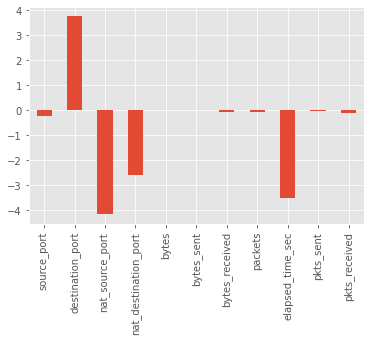

In [29]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=column_names)
weights.plot(kind='bar')
plt.show()

In [33]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
#svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # run first
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # run second
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)


accuracy: 0.9976392007830944
[[12305    36]
 [    5  5021]]


In [34]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(1025, 11)
(1025,)
[513 512]


[[-1.56393312e-02  3.24779351e-01 -6.74543783e+00 -2.01032943e+00
  -1.69749817e-01 -3.50947032e-02 -3.44557315e-01 -3.95355358e-01
  -1.63462542e+01 -2.50001453e-01 -5.74854970e-01]]
[-10.81284134]


<AxesSubplot:>

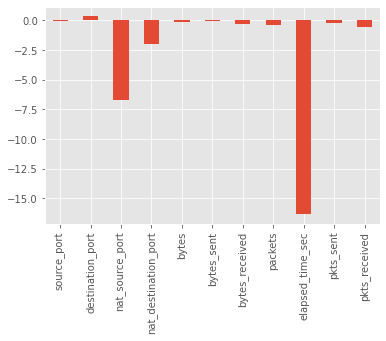

In [35]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
print(svm_clf.intercept_)
orig_cols = master_data['custom_table'].columns.tolist()
orig_cols.remove(target.value)
weights = pd.Series(svm_clf.coef_[0],index=orig_cols)
weights.plot(kind='bar')

In [36]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = master_data['custom_table'].iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support[target.value] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
master_data['custom_table'][target.value] = y # also add it back in for the original data
df_support.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1025 entries, 45813 to 59781
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   source_port           1025 non-null   int64 
 1   destination_port      1025 non-null   int64 
 2   nat_source_port       1025 non-null   int64 
 3   nat_destination_port  1025 non-null   int64 
 4   action                1025 non-null   object
 5   bytes                 1025 non-null   int64 
 6   bytes_sent            1025 non-null   int64 
 7   bytes_received        1025 non-null   int64 
 8   packets               1025 non-null   int64 
 9   elapsed_time_sec      1025 non-null   int64 
 10  pkts_sent             1025 non-null   int64 
 11  pkts_received         1025 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 104.1+ KB


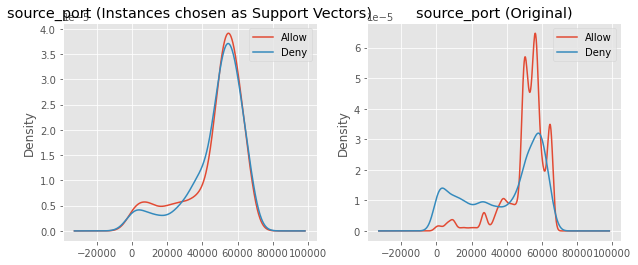

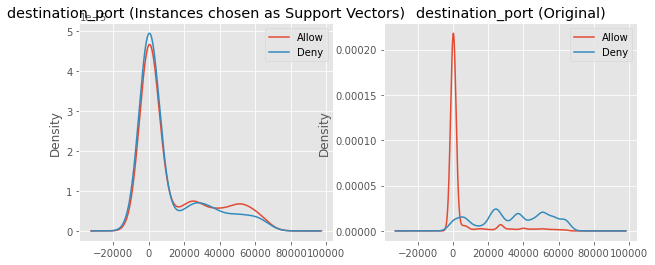

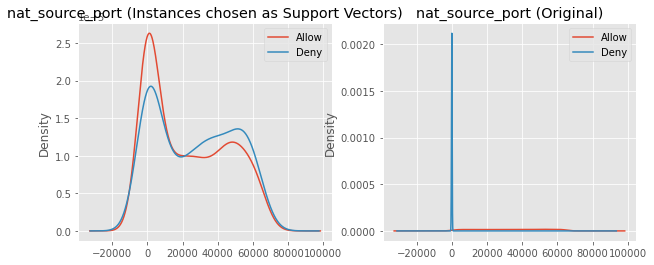

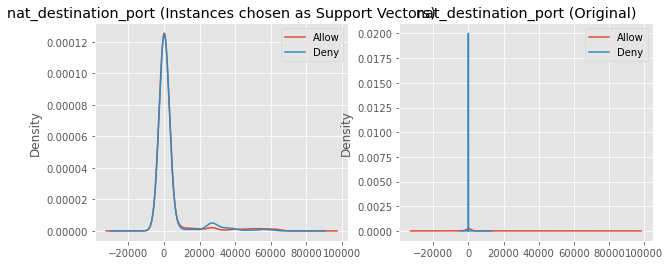

In [37]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby([target.value])
df_grouped = master_data['custom_table'].groupby([target.value])

# plot KDE of Different variables
vars_to_plot = ['source_port','destination_port','nat_source_port','nat_destination_port']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Allow','Deny'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Allow','Deny'])
    plt.title(v+' (Original)')

The analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.

In [92]:
import h2o
from h2o.estimators import H2OSupportVectorMachineEstimator

In [89]:
try:
    h2o.cluster().shutdown()
    h2o.init()
except:
    h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 mins 34 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,3 months and 11 days !!!
H2O_cluster_name:,H2O_from_python_bblanchard006_ocnq4f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.485 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [90]:
df = master_data['custom_table'].dropna(subset=[target.value])
df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
svm_model = H2OSupportVectorMachineEstimator(gamma=0.01,
                                             rank_ratio = 0.1,
                                             disable_training_metrics = False)
svm_model.train(y = target.value, training_frame = df)

psvm Model Build progress: |████████Job request failed Unexpected HTTP error: HTTPConnectionPool(host='localhost', port=54321): Max retries exceeded with url: /3/Jobs/$03017f00000132d4ffffffff$_887b798425b5afabcbd92c5f9cd34d27 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f81b0a819a0>: Failed to establish a new connection: [Errno 61] Connection refused')), will retry after 3s.
Job request failed Unexpected HTTP error: HTTPConnectionPool(host='localhost', port=54321): Max retries exceeded with url: /3/Jobs/$03017f00000132d4ffffffff$_887b798425b5afabcbd92c5f9cd34d27 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f81400f74c0>: Failed to establish a new connection: [Errno 61] Connection refused')), will retry after 3s.
Job request failed Unexpected HTTP error: HTTPConnectionPool(host='localhost', port=54321): Max retries exceeded with url: /3/Jobs/$03017f00000132d4ffffffff$_887b798425b5afabcbd92c5f9cd34d27 (Caused by NewConne

In [ ]:
# Eval performance:
perf = svm_model.model_performance()

# Generate predictions (if necessary):
pred = svm_model.predict(df)